In [1]:
import cv2
import numpy as np
import pandas as pd
import os  
from random import shuffle
from IPython.display import display, Markdown
from tqdm import tqdm
import PIL
from PIL import Image
import seaborn as sn
from itertools import cycle
from keras import losses
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from matplotlib.pyplot import imshow
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sn.set()

df = pd.read_csv('data/individual_details.csv')

img_path = 'mugshots/mugs'
img_w = 120
img_h = 150
learning_rate = .001

Using TensorFlow backend.


In [2]:
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['bday'] = pd.to_datetime(df['bday'])

df['age'] = round((df["booking_date"] - df["bday"]).dt.days / 365)

In [3]:
Y = df['age'].values
X = df.drop(columns=['age'])

In [4]:
df.head()

,booking_number,booking_date,sex,height,weight,eye_color,hair_color,bday,crime_type_expanded,age
0,T626990,2020-03-18,MALE,6'02,155,BROWN,BROWN,1996-12-16,"['THREAT-INTIMIDATE-GANG', 'AGGRAVATED ROBBERY...",23.0
1,T626991,2020-03-18,MALE,5'11,250,BROWN,BLACK,1976-04-12,"['AGG ASLT-DEADLY WPN/DANG INST', 'DISORDERLY ...",44.0
2,T626994,2020-03-18,MALE,5'06,190,BROWN,BLACK,1993-10-27,"['PROBATION VIOLATION', 'AGG ASLT-DEADLY WPN/D...",26.0
3,T626995,2020-03-18,MALE,5'09,140,BROWN,BROWN,1998-01-07,"['RESIST ARREST-RISK PHYS INJ', 'CRIMINAL DAMA...",22.0
4,T626997,2020-03-18,FEMALE,5'05,115,BROWN,BROWN,1973-07-16,['CHILD/VUL ADULT ABUSE-INTENT'],47.0


In [5]:
mug_id = list(df.booking_number)

In [6]:
def process_img():
    processed_data = []
    i = 0
    for img in tqdm(mug_id):
        path = os.path.join(img_path,img+'.png')
        
        img = cv2.imread(path)
                
        if np.shape(img) != ():
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_w,img_h))
            processed_data.append([np.array(img),np.array(int(Y[i]))])
            i+=1
        else:
            pass
        
    shuffle(processed_data)

    return processed_data


# split data into train and test
def split_img(img, train=.6):
    length = len(img)
    cut_off = round(len(images)*train)
    
    return img[:cut_off], img[cut_off:]

In [7]:
images = process_img()

100%|██████████| 4746/4746 [00:17<00:00, 268.45it/s]


# Keras

In [8]:
train, test = split_img(images)

trainImages = np.array([i[0] for i in train]).reshape(-1, img_w, img_h, 3)
trainLabels = np.array([i[1] for i in train])

In [9]:
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [10]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(img_w, img_h, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
optimizer = keras.optimizers.RMSprop(0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=[rmse])

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [12]:
history = model.fit(trainImages,
          trainLabels,
          batch_size=50,
          epochs=50,
          validation_split=.2,
          verbose=1,
          callbacks=[early_stop])


Train on 2256 samples, validate on 565 samples
Epoch 1/50
2256/2256 [==============================] - 23s 10ms/step - loss: 232.2684 - rmse: 11.4143 - val_loss: 346.1966 - val_rmse: 15.2070
Epoch 2/50
2256/2256 [==============================] - 23s 10ms/step - loss: 126.2344 - rmse: 8.7534 - val_loss: 158.2598 - val_rmse: 9.8241
Epoch 3/50
2256/2256 [==============================] - 23s 10ms/step - loss: 123.6668 - rmse: 8.6557 - val_loss: 198.4416 - val_rmse: 12.0279
Epoch 4/50
2256/2256 [==============================] - 23s 10ms/step - loss: 115.6037 - rmse: 8.4556 - val_loss: 279.2468 - val_rmse: 13.9641
Epoch 5/50
2256/2256 [==============================] - 23s 10ms/step - loss: 116.4417 - rmse: 8.4625 - val_loss: 277.4990 - val_rmse: 14.1107
Epoch 6/50
2256/2256 [==============================] - 23s 10ms/step - loss: 111.3926 - rmse: 8.2569 - val_loss: 164.6113 - val_rmse: 9.5254
Epoch 7/50
2256/2256 [==============================] - 23s 10ms/step - loss: 110.5779 - rmse: 

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_rmse,loss,rmse,epoch
20,138.882507,9.436784,36.084372,4.688547,20
21,158.615688,9.569080,35.911656,4.691065,21
22,178.877687,10.251877,30.975018,4.352372,22
23,150.138084,9.504941,32.431103,4.472970,23
24,216.725783,11.292723,28.207909,4.122970,24


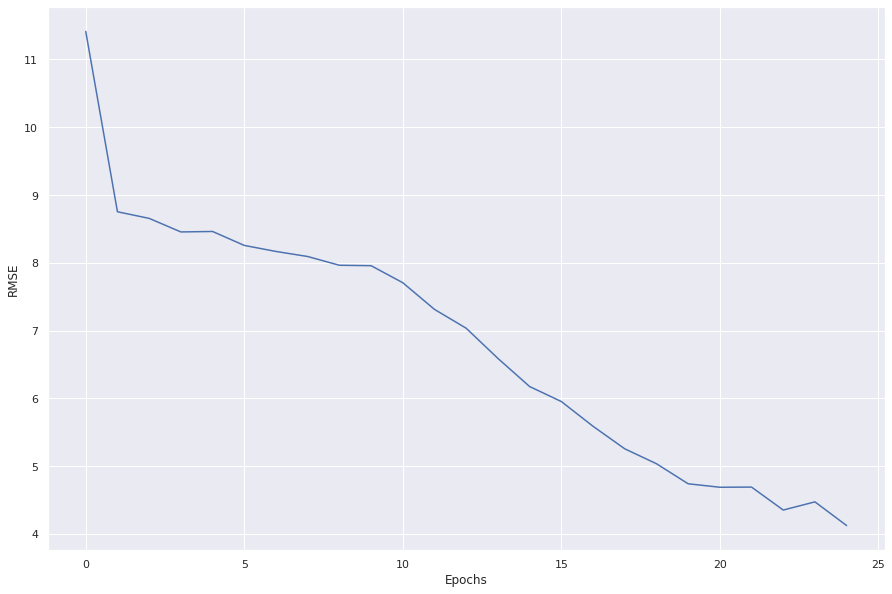

In [14]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['rmse'])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

In [15]:
testImages = np.array([i[0] for i in test]).reshape(-1, img_w, img_h, 3)
testLabels = np.array([i[1] for i in test])

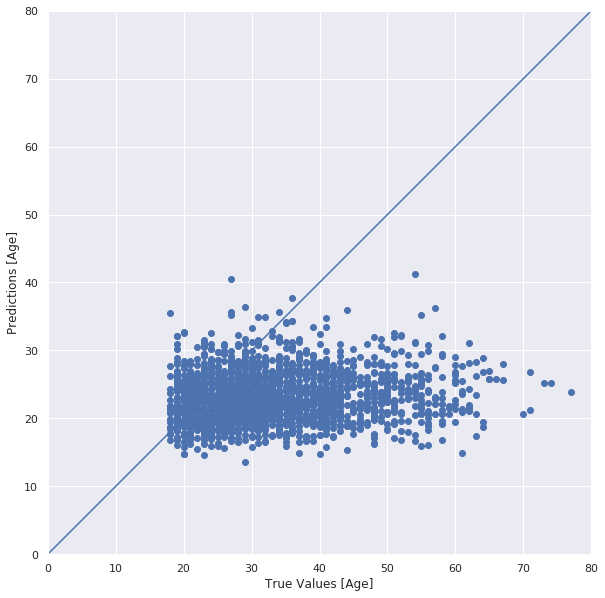

In [16]:
test_predictions = model.predict(testImages).flatten()
plt.figure(figsize=(15, 10))

a = plt.axes(aspect='equal')
plt.scatter(testLabels, test_predictions)
plt.xlabel('True Values [Age]')
plt.ylabel('Predictions [Age]')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

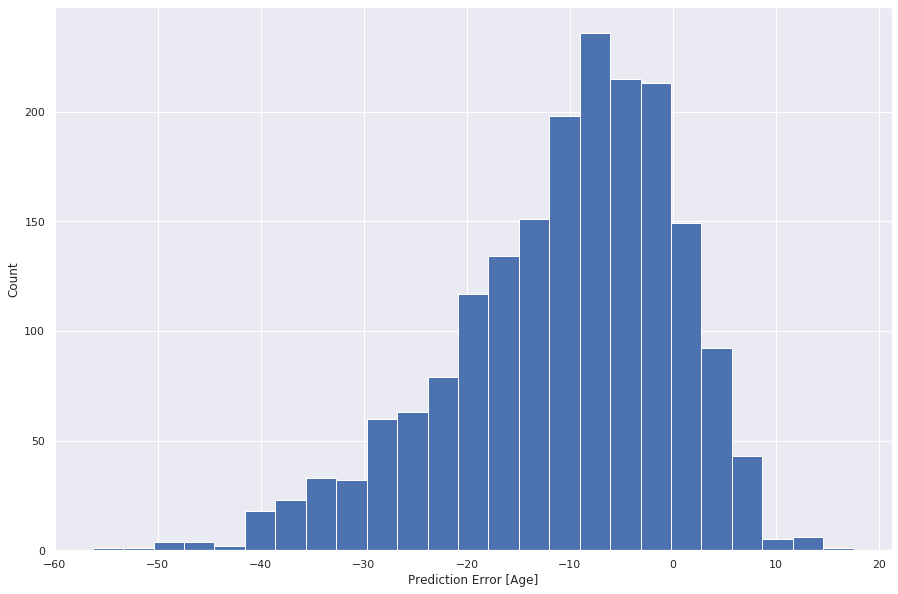

In [17]:
error = test_predictions - testLabels
plt.figure(figsize=(15, 10))
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Age]")
_ = plt.ylabel("Count")

In [18]:
model.evaluate(testImages, testLabels, verbose = 0)

[233.3521626573928, 11.715309143066406]

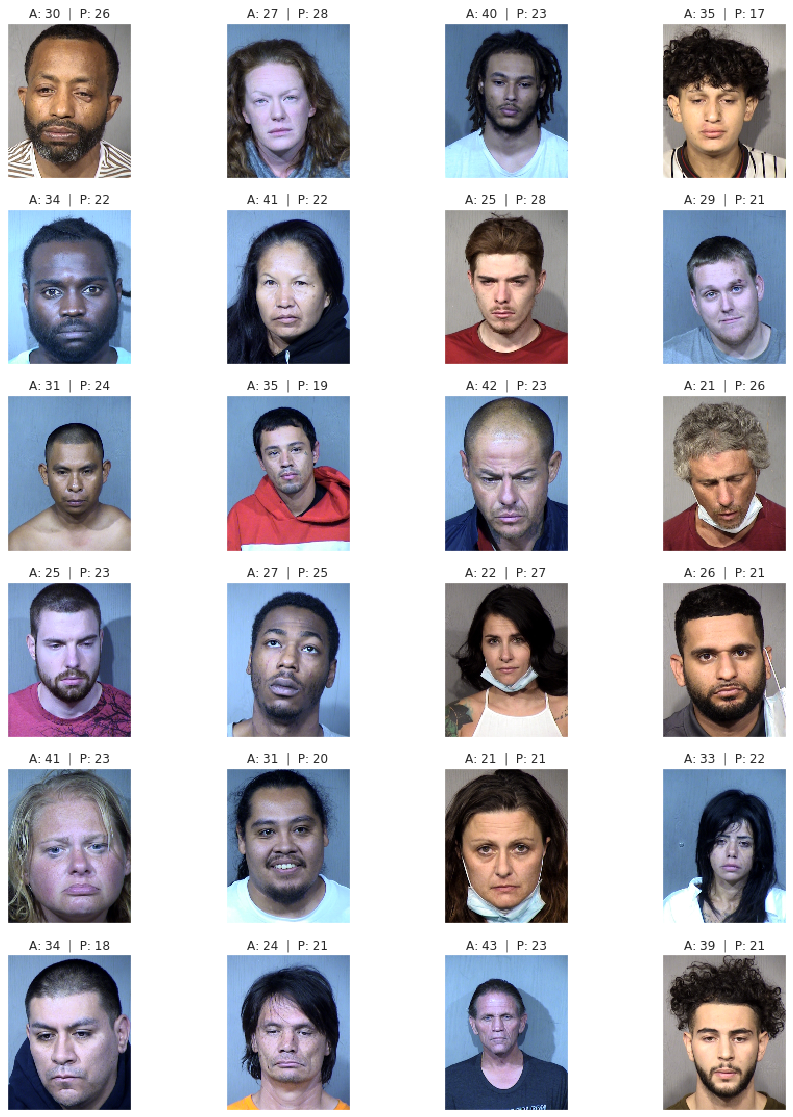

In [19]:
fig=plt.figure(figsize=(15, 20))

for num,data in enumerate(images[-24:]):

    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(6,4,num+1)
    orig = img_data
    data = img_data.reshape(-1, img_w, img_h, 3)

    model_out = model.predict([data])
        
    y.imshow(orig)
    plt.title(f'A: {int(img_num)}  |  P: {int(round(model_out[0][0]))}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()